# Mateix codi però amb els valors de les constants de l'article de Moncho

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import dedalus.public as d3
from scipy.optimize import fsolve
import logging
import matplotlib.ticker as ticker
logger = logging.getLogger(__name__)
from IPython.display import display
import scienceplots
plt.style.use('science')



""" Funcions per calcular els autovalors exactes """
# Funcions den Monxo per calcular els autovalors exactes d'una corda amb densitat variable.
def dispersion_relation(omega):
    disprel_even = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2))
    disprel_odd = (np.sqrt(cp2)/np.sqrt(cc2)) * np.cos(omega * (xmax - xp) / np.sqrt(cc2)) * np.sin(omega * xp / np.sqrt(cp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(cc2)) * np.cos(omega * xp / np.sqrt(cp2))
    disprel = disprel_even * disprel_odd
    return disprel

def dispersion_relation2(omega):
    disprel_even2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2)) - \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2))
    disprel_odd2 = (np.sqrt(vAp2)/np.sqrt(vAc2)) * np.cos(omega * (xmax - xp) / np.sqrt(vAc2)) * np.sin(omega * xp / np.sqrt(vAp2)) + \
        np.sin(omega * (xmax - xp) / np.sqrt(vAc2)) * np.cos(omega * xp / np.sqrt(vAp2))
    disprel2 = disprel_even2 * disprel_odd2
    return disprel2

def get_eigenvalues(Nevals):
    Nsol = 0
    omega0 = 1
    omega_step = 0.5
    exact_soln = np.array([])
    while Nsol < Nevals:
        sol = fsolve(dispersion_relation, omega0)
#         print('omega0, sol ', omega0, sol)
        sol2 = fsolve(dispersion_relation2, omega0)

        if sol > 0:
            exact_soln = np.append(exact_soln, sol)
            exact_soln = np.unique(exact_soln.round(decimals=8))
#         print('exact_soln, exact_soln**2 ', exact_soln, exact_soln**2)
#         print(exact_soln.size)
        if sol2 > 0:
            exact_soln = np.append(exact_soln, sol2)
            exact_soln = np.unique(exact_soln.round(decimals=8))

        Nsol = exact_soln.size
        omega0 = omega0 + omega_step
#    print('exact_soln ', exact_soln[0:5])
#    print('exact_soln**2 ', exact_soln**2)
    print()
    return exact_soln



""" Exact parameters """
def MHD_params(T0p, T0c, rho0p, B0, multildep, multildec):
    # Physical constants in SI units.
    kB = 1.38e-23
    mp = 1.67e-27
    capR = kB / mp
    mu = np.pi * 4e-7
    gamma = 5/3

    # Parameter values in SI units.
    #B0 = 5e-4 # encara que no surti directament a ses equacions el feim servir per fer calcular altres constants.
    #T0p = 8e3
    #multildep = 0.8
    #rho0p = 5e-11
    #T0c = 1e6
    #multildec = 0.5

    p0 = rho0p * capR * T0p / multildep
    rho0c = p0 / (capR * T0c / multildec)
    print('p0 ', p0)
    print('rho0c ', rho0c)
    rho0c = rho0p * T0p / multildep / (T0c / multildec)
    print("rho0c ", rho0c)
    # Sound and Alfvén speeds.
    csp = np.sqrt(gamma * capR * T0p / multildep)
    # csp = np.sqrt(gamma * p0 / rho0p)
    vAp = B0 / np.sqrt(mu * rho0p)
    csc = np.sqrt(gamma * capR * T0c / multildec)
    # csc = np.sqrt(gamma * p0 / rho0c)
    vAc = B0 / np.sqrt(mu * rho0c)
    return csp, csc, vAp, vAc

csp, csc, vAp, vAc = MHD_params(T0p=8e3, T0c=1e6, rho0p=5e-11, B0=5e-4, multildep=0.8, multildec=0.5)
cp2 = csp * csp # 1
cc2 = csc * csc # 6
vAp2 = vAp * vAp # 10
vAc2 = vAc * vAc # 36

print('csp, csc, vAp, vAc ', csp, csc, vAp, vAc)
print('cp2, cc2, vAp2, vAc2 ', cp2, cc2, vAp2, vAc2)


""" Paràmetres """
Nx = 128 # Nombre de punts de la malla (128, 256, 512, 1024, 2048)
dtype = np.complex128 # malla en la que es treballa: 128 complexes, ja que hem definit Nx = 128



""" Límits del domini """
xmax = 6000 # xc
xmin = -6000 # = -xmax
# Position of boundaries between different parts of the system (prominence and corona).
xp = 3000
# xc ∈ [-1, -0.1], xc ∈ [0.1, 1]



""" Constants """
kz = 0.01
#B0 = 0

### Redefinim les velocitats a trossos manualment... ###
cp2 = 12
cc2 = 166
vAp2 = 63
vAc2 = 892
# Valors realistes: cp2, cc2, vAp2, vAc2  137724550.89820358 27544910179.640717 3978873577.297384 795774715459.4768



""" Bases """
xcoord = d3.Coordinate('x')
dist = d3.Distributor(xcoord, dtype=dtype)
xbasis = d3.Legendre(xcoord, size=Nx, bounds=(xmin, xmax)) # Definim una base amb uns altres límits. Chebyshev menos error?



""" Camps """
### Velocitats ###
u = dist.Field(name='u', bases=xbasis) # u = field of the wave function - AUTOFUNCIÓ!!! - v10x bar, coplexa
w = dist.Field(name='w', bases=xbasis) # w = Velocity in the x direction   v10z - real
# Definesc la velocitat com en oceano: (u,v,w) per no liar subíndexos i derivades.

### Espai real ###
x = dist.local_grid(xbasis)

### Constants ###
c2 = dist.Field(name='c2', bases=xbasis) # c2 = Velocitat al quadrat ----- és interessant definir-la directament al quadrat ja que és un camp i així evitam fer c.evaluate()**2
c2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [cc2, cp2, cc2]) # Representa la c^2 en l'espai real ('g') a trossos.
vA2 = dist.Field(name='vA2', bases=xbasis) # vA2 = Alfven velocity squared
vA2['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [vAc2, vAp2, vAc2]) # Representa la velocitat d'Alfven en l'espai real ('g') a trossos.

### Autovalors ###
s = dist.Field(name='s') # AUTOVALOR ω^2 = s

### Camps magnètics ###
#Bx = dist.Field(name='Bx', bases=xbasis) # Bx = Magnetic field in the x direction   B10x
#Bz = dist.Field(name='Bz', bases=xbasis) # Bz = Magnetic field in the z direction   B10z

### Densitats ###
#rho0 = dist.Field(name='rho0', bases=xbasis) # rho0 = Density of the plasma  ρ0
#rho10 = dist.Field(name='rho10', bases=xbasis) # rho = Variation density of the plasma   ρ10
#rho10['g'] = np.piecewise(x, [x < -xp, (-xp <= x) * (x <= xp), x > xp], [1, 1, 1]) # Representa la densitat en l'espai real ('g') a trossos.

### Auxiliars de les derivades ###
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
tau_3 = dist.Field(name='tau_3')
tau_4 = dist.Field(name='tau_4')



""" Derivades """
### Derivades espacials ###
dx = lambda A: d3.Differentiate(A, xcoord) # Derivative operator
lift_basis = xbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
ux = dx(u) + lift(tau_1) # First-order reduction of the velocity in the x direction
uxx = dx(ux) + lift(tau_2) # Second-order reduction of the velocity in the x direction
wx = dx(w) + lift(tau_3) # First-order reduction of the velocity in the z direction
wxx = dx(wx) + lift(tau_4) # Second-order reduction of the velocity in the z direction
# No és convenient posar directament dx(u) a l'equació ja que faltaria el lift... s'ha de definir bé la derivada
# No definim derivada temporal ja que és un EVP!!!

# RESOLDRE PRIMER SUBSTITUINT Bx, Bx i RHO i només resolent 2 eqs... i 4 eqs de contorn, només resolem per u i w, eqs. (17') i (19')



""" Problema """
### Problema d'ones ràpida i lenta (complet) ###
#problem = d3.EVP([u, w, Bx, Bz, rho0, rho10, tau_1, tau_2,], eigenvalue=s, namespace=locals())
#problem.add_equation("np.sqrt(s)*rho10 + rho0*(-wx - kz*w) =0 ") # (12)
#problem.add_equation("np.sqrt(s)*Bx = kz*B0*w") # (14)
#problem.add_equation("np.sqrt(s)*Bz = B0*ux") # (16)
#problem.add_equation("np.sqrt(s)*rho10*ux = -c2*rho10x ") # (17)
#problem.add_equation("np.sqrt(s)*rho10*w - c2*kz*rho10 - vA2*(rho/B0)*(kz*Bx -Bzx) = 0") # (19)

### Problema d'ones d'Alfvén ### ~ corda guitarra amb densitat variable
#problem = d3.EVP([u, tau_1, tau_2], eigenvalue=s, namespace=locals())
#problem.add_equation("s * u  +  vA2 * uxx  =  0") # (12)

### Problema d'ones ràpida i lenta (més treballat) ###
problem = d3.EVP([u, w, tau_1, tau_2, tau_3, tau_4], eigenvalue=s, namespace=locals()) # 2 equacions i 4 incògnites
# problem.add_equation("s * u  +  c2 * uxx  =  0") # (17') # amb kz = 0
# problem.add_equation("s * w  +  vA2 * wxx  =  0") # (19') # amb kz = 0. Hauríem d'obtenir una molt semblant a la (17') però amb la velocitat en z i la constant d'Alfvén
problem.add_equation("s * u  +  c2 * uxx  +  kz * c2 * wx  =  0") # (17')
problem.add_equation("vA2 * wxx  +  c2 * kz * ux  +  (-c2 * kz**2 - vA2 * kz**2 + s) * w  =  0") # (19')
problem.add_equation("u(x=xmin) = 0")
problem.add_equation("u(x=xmax) = 0")
problem.add_equation("w(x=xmin) = 0")
problem.add_equation("w(x=xmax) = 0")
print("Number of unknowns:", len(problem.variables))
print("Number of equations:", len(problem.equations))



""" Solver """
### Solver de Dedalus ###
solver = problem.build_solver()
#print(solver.subproblems)
solver.solve_dense(solver.subproblems[0])
evals = np.sort(solver.eigenvalues)

### Ajustament de les autofuncions ###
print('evals.size (before) ', evals.size)
#evals = evals[~np.isinf(evals)] # el ~ és un operador bitwise NOT, que retorna True si el valor és False i viceversa. En aquest cas elimina els valors infinits
print('evals.size (after removing inf) ', evals.size)
evals = evals[evals > 0] # eliminam els valors negatius
print('evals.size (after removing < 0) ', evals.size)
evals = np.sqrt(evals)

### Autovalors exactes ###
Nevals = evals.size
exact_soln = get_eigenvalues(Nevals)
n = 1 + np.arange(evals.size)
true_evals = exact_soln[0:evals.size]

### Error relatiu ###
relative_error = np.abs(evals - true_evals) / true_evals

### Autovalors ###
print('evals size', evals.size)
print("true_evals size ", true_evals.size)
#print("Evals", evals)
#print("True Evals", true_evals)

# Agafam la part real per fer un print més net
evals = evals.real
print("First 5 Eigenvalues (sqrt):", evals[:5])
print("First 5 True eigenvalues:", true_evals[:5])
print("Relative error:", relative_error[:5])
print()  # This adds a blank line


Number of unknowns: 6
Number of equations: 6
2025-05-14 20:38:12,425 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 10s, Remaining: 0s, Rate: 9.6e-02/s
evals.size (before)  260
evals.size (after removing inf)  260
evals.size (after removing < 0)  258

evals size 258
true_evals size  258
First 5 Eigenvalues (sqrt): [0.00103976 0.0022884  0.00385524 0.00542869 0.00723515]
First 5 True eigenvalues: [1.00007887 1.00357612 1.50040772 1.50076786 1.99594935]
Relative error: [0.99896032 0.99771976 0.99743054 0.99638273 0.99637508]



# Representació de l'error

[]

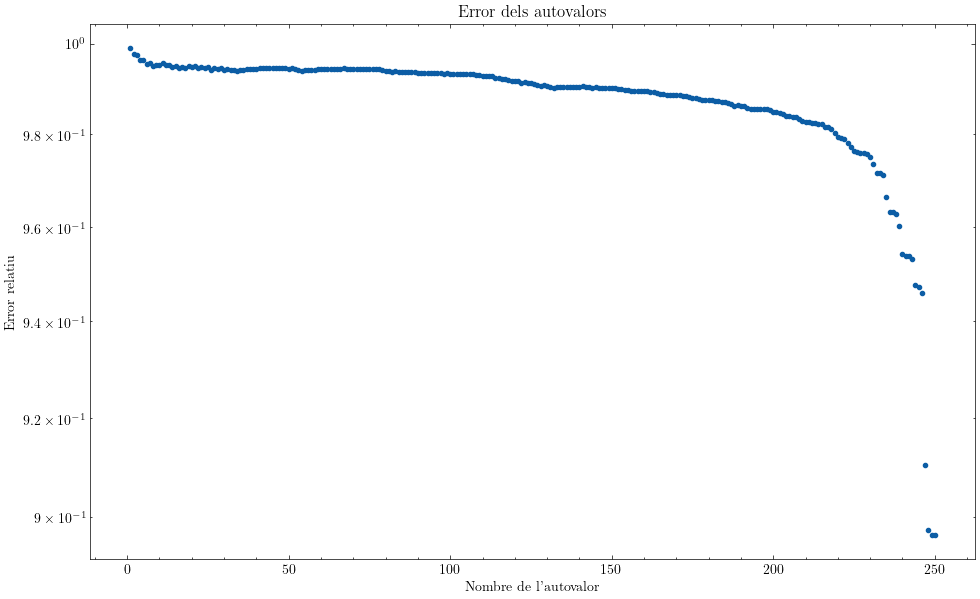

In [2]:
plt.figure(figsize=(10, 6))
plt.semilogy(n, relative_error, '.')
plt.xlabel("Nombre de l'autovalor")
plt.ylabel("Error relatiu")
plt.tight_layout()
plt.title("Error dels autovalors")
plt.grid(False)
plt.plot()
#plt.savefig('eigenvalue_error.png', dpi=300)

# Representació de les autofuncions

Maximum value is wg = 1.3284600226174512 and minimum value is ug = 1.0
Maximum value is ug = 1.3291893065220168 and minimum value is wg = 1.0000000000050544
Maximum value is ug = 685.7679729721118 and minimum value is wg = 15.064704790003303
Maximum value is ug = 461.18787366870777 and minimum value is wg = 21.39656886433637


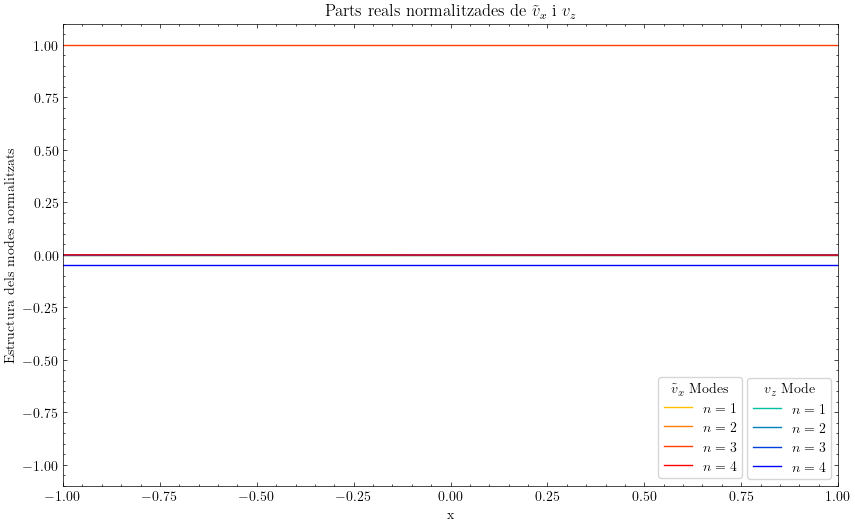

In [3]:
### Nombre de modes que volem representar ###
N_max_mode = 4
N_min_mode = 0
N_modes = N_max_mode - N_min_mode

### Define warm and cold color palettes ###
cmap_warm = plt.get_cmap('autumn')  # Warm color palette for v10x~
cmap_cold = plt.get_cmap('winter')   # Cold color palette for v10z
colors_warm = [cmap_warm(i / N_modes) for i in range(N_modes)]    # Warm colors
colors_cold = [cmap_cold(i / N_modes) for i in range(N_modes)]    # Cold colors

### Create lists to store handles for legends ###
handles_v10x = []
handles_v10z = []

### Plot ug.real and wg.real and normalize to the maximum value ###

x = dist.local_grid(xbasis)
ug_max_list = []
ug_min_list = []
wg_max_list = []
wg_min_list = []
plt.figure(figsize=(10, 6))
for n, idx in enumerate(np.argsort(solver.eigenvalues)[N_min_mode:N_max_mode], start=1):
    solver.set_state(idx, solver.subsystems[0])
    ug = u['g'].real/(u['g'][1]).real
    wg = w['g'].real/(w['g'][1]).real
    ui = u['g'].imag/(u['g'][1]).imag
    wi = w['g'].imag/(w['g'][1]).imag
    
    # Find the maximum absolute value between ug and wg
    max_val = np.max(np.abs(np.concatenate([ug, wg])))

    # Print the maximum value
    if np.max(np.abs(ug)) > np.max(np.abs(wg)):
        print("Maximum value is ug =", max_val,"and minimum value is wg =", np.max(np.abs(wg)))
    else:
        print("Maximum value is wg =", max_val,"and minimum value is ug =", np.max(np.abs(ug)))

    # Normalize both ug and wg by the maximum value
    ug_normalized = ug / max_val
    wg_normalized = wg / max_val

    # Append the values to the lists to display in the DataFrame
    ug_max_list.append(np.max(ug_normalized))
    ug_min_list.append(np.min(ug_normalized))
    wg_max_list.append(np.max(wg_normalized))
    wg_min_list.append(np.min(wg_normalized))

    # Plot v10x~ with warm colors and store the handle
    handle_v10x, = plt.plot(x, ug_normalized, label=fr"$n={n}$", color=colors_warm[ - n])
    handles_v10x.append(handle_v10x)

    # Plot v10z with cold colors and store the handle
    handle_v10z, = plt.plot(x, wg_normalized, label=fr"$n={n}$", color=colors_cold[ - n])
    handles_v10z.append(handle_v10z)

    # Create a DataFrame to display the results
    data = {
        "Mode": [f"Mode {i+1}" for i in range(len(ug_max_list))],
        "ug_max": ug_max_list,
        "wg_max": wg_max_list,
        "ug_min": ug_min_list,
        "wg_min": wg_min_list,}
    df = pd.DataFrame(data)

## Create separate legends
legend_v10x = plt.legend(handles=handles_v10x, title=r"$\tilde{v}_{x}$ Modes", loc="upper right", bbox_to_anchor=(0.885, 0.25), frameon=True)
plt.gca().add_artist(legend_v10x)  # Add the first legend to the plot
plt.legend(handles=handles_v10z, title=r"$v_{z}$ Mode", loc="lower right", bbox_to_anchor=(1, 0), frameon=True)


plt.xlim(-1, 1)
#plt.legend(loc="lower right", frameon=True)
plt.ylabel(r"Estructura dels modes normalitzats")
plt.xlabel(r"x")
plt.title(r"Parts reals normalitzades de $\tilde{v}_{x}$ i ${v}_{z}$")
plt.grid(False)
plt.savefig('normalized_modes.png', dpi=300, bbox_inches='tight')
plt.show()



# Tal vegada em pot interessar normalitzar en un bucle i després representar per separat. No representar tot de cop... però sí pq les vull comparar en tamany...

# A l'hora de representar la part real de les autofuncions has de tenir clar que la velocitat u és en la direcció x i la w en z. També que v10x és imaginària i v10z és real.
# A més, el que es representa és la velocitat, no la corda en sí. Llavors un node implica velocitat nul·la: aquell punt no es mou.
# Els màxims i mínims són els punts on la velocitat és màxima, no és que la corda es deformi amb aquella forma.

# Ficar els plots de les velocitats dins el for i representar les velocitats per cada kz... pot tardar bastant però crec que és el que he de fer!

# No entenc molt bé perquè els modes no es van alternant, és a dir, els modes senars el màxim hauria de ser ug i els parells wg; NO ESTÀ PASSANT AIXÒ PERÒ!